# Predict the cost on a larger dataset 
* Charges is dependant variable
* Others are independant
* One-hot encoding is used

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import plot_model

SEED = 42


In [2]:
from sklearn.model_selection import train_test_split as ts_split
import numpy as np
plt.rcParams["figure.figsize"] = (10,5)

In [3]:
%pwd

'd:\\Learning\\Deep Learning'

In [4]:
data = pd.read_csv("./Datasets/insurance.csv")
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [5]:
one_hot = pd.get_dummies(data)
one_hot.head(5)  

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,True,False,False,True,False,False,False,True
1,18,33.770,1,1725.55230,False,True,True,False,False,False,True,False
2,28,33.000,3,4449.46200,False,True,True,False,False,False,True,False
3,33,22.705,0,21984.47061,False,True,True,False,False,True,False,False
4,32,28.880,0,3866.85520,False,True,True,False,False,True,False,False


In [6]:
X = one_hot.drop("charges", axis=1) # add data without charges
X


,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,True,False,False,True,False,False,False,True
1,18,33.770,1,False,True,True,False,False,False,True,False
2,28,33.000,3,False,True,True,False,False,False,True,False
3,33,22.705,0,False,True,True,False,False,True,False,False
4,32,28.880,0,False,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,False,True,True,False,False,True,False,False
1334,18,31.920,0,True,False,True,False,True,False,False,False
1335,18,36.850,0,True,False,True,False,False,False,True,False
1336,21,25.800,0,True,False,True,False,False,False,False,True


In [7]:
Y = one_hot["charges"] # add only charges data
Y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [8]:
ts_split

<function sklearn.model_selection._split.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)>

In [9]:
x, y = {"train": None,"test": None}, {"train": None,"test": None,}
x["train"], x["test"], y["train"], y["test"] = ts_split(X, Y, test_size=0.2, random_state=42)

[(len(x[key]),len(y[key])) for key in x.keys()], type(x["train"])

([(1070, 1070), (268, 268)], pandas.core.frame.DataFrame)

In [10]:
for key in x.keys():
    x[key], y[key] = np.asarray(x[key]).astype(np.float32), np.asarray(y[key]).astype(np.float32)
x["train"].shape, y["train"].shape

((1070, 11), (1070,))

In [11]:
import keras

In [12]:
class Model:

    def __init__(self, seed: int = 42):
        plt.rcParams["figure.figsize"] = (10, 5)
        tf.random.set_seed(seed)
        self.model = keras.Sequential()
        self.datset_init()

    def datset_init(self, x=x, y=y):
        self.x_train = x["train"]
        self.y_train = y["train"]
        self.x_test = x["test"]
        self.y_test = y["test"]
        ...

    def new_model(self, *hidden_units: int):
        # Input Layer
        input_shape = self.x_train.shape[1:]
        if input_shape is not None:
            self.model.add(keras.layers.InputLayer(input_shape=input_shape))
        else:
            self.model.add(keras.layers.InputLayer())
        # Hidden Layers
        for key in hidden_units:  # More flexible units and layers imporves the odel
            self.model.add(keras.layers.Dense(key, activation="relu"))
        # Output Layer
        self.model.add(keras.layers.Dense(1))

    def train(self,
              lr: float = 0.001,
              epochs: int = 100,
              verbose: int = 0):
        self.model.compile(loss=keras.losses.mae,
                           optimizer=keras.optimizers.Adam(learning_rate=lr),
                           metrics=["mae"])
        history = self.model.fit(self.x_train, self.y_train,
                                 epochs=epochs, verbose=verbose)
        return history

    def predict(self):
        self.pred = self.model.predict(self.x_test)
        return self.pred

    def plot(self, generic: bool = False):
        self.predict()
        plot_model(model=self.model)
        if generic:
            self.metric = np.array([x["test"][i][0]
                                    for i in range(len(x["test"]))])
            print(self.metric.shape, self.y_train.shape,
                  self.y_test.shape, self.pred.shape)
        else:
            self.metric = self.y_test
        # plt.scatter(self.metric, self.y_train, label="Trained")
        plt.scatter(self.metric, self.y_test, label="Expected")
        plt.scatter(self.metric, self.pred, label="Predicted")
        plt.legend()
        plt.show()

    def eval_metric(self):
        print(self.model.evaluate(self.x_test, self.y_test))
        y_test_ = tf.squeeze(self.y_test)
        pred_ = tf.squeeze(self.predict())
        huber = keras.losses.Huber()
        mae = keras.metrics.MAE(y_test_, pred_).numpy()
        mse = keras.metrics.MSE(y_test_, pred_).numpy()
        h = huber(y_test_, pred_).numpy()
        # print(f"MAE: {mae}\nMSE: {mse}\nHuber: {h}")
        return {
            "mae": mae,
            "mse": mse,
            "huber": h
        }

    def plot_compare(self):
        a = self.y_test
        b = self.pred.reshape(1, -1)[0]
        fig, ax = plt.subplots()
        ax.scatter(np.arange(len(a)), a, label='Expected')
        ax.scatter(np.arange(len(b)), b, label='Predicted')
        for i in range(len(a)):
            ax.plot([i, i], [a[i], b[i]], color='gray')
        ax.legend()
        plt.show()

In [13]:
class View:
    def __init__(self) -> None:
        self.df = []

    def compare(self, *metrics: dict):
        cols = []
        for i in metrics:
            res = [v for v in i.values()]
            cols = [k for k in i.keys()]
            self.df.append(res)
        return pd.DataFrame(self.df, columns=cols)

    def loss_plot(self, history):
        return pd.DataFrame(history.history).plot()
        ...

In [14]:
class Create:
    def __init__(self, epochs: int = 10, 
                 hidden_layers: int = ..., 
                 hidden_units: int = ..., 
                 verbose: int = 0, 
                 lr: float = 0.01):
        self.model = Model()
        self.view = View()
        self.model.new_model(*(hidden_units for i in range(hidden_layers)))
        self.history = self.model.train(lr=lr, epochs=epochs, verbose=verbose)

    def visualise(self, generic: bool = False):
        self.model.predict()
        self.model.model.summary()
        self.model.plot_compare()
        self.model.plot(generic=generic)
    def data(self):
        self.view.loss_plot(self.history)
        self.view.compare(self.model.eval_metric())
        return self.history, self.model.eval_metric()
        ...

In [15]:
p = Create(hidden_layers=3, epochs=1000, hidden_units=10)

9/9 [==============================] - 0s 2ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                120       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 351 (1.37 KB)
Trainable params: 351 (1.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


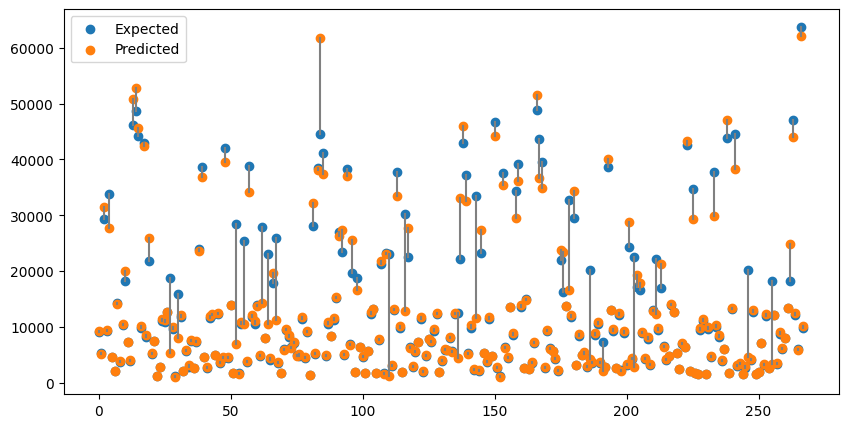

9/9 [==============================] - 0s 2ms/step


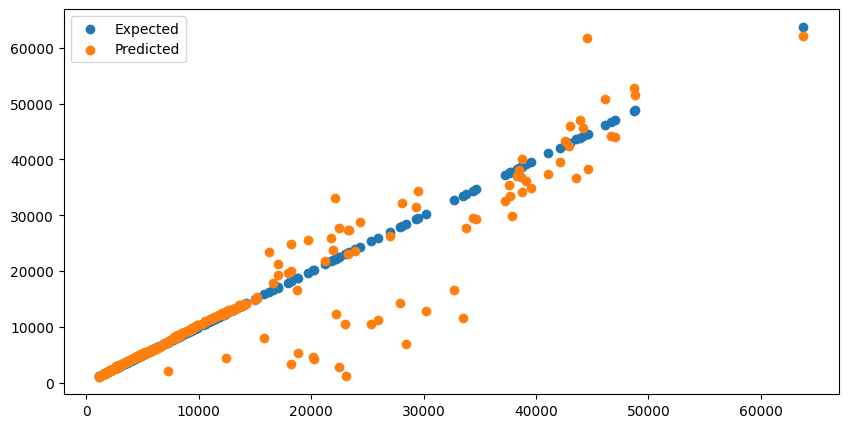

9/9 [==============================] - 0s 2ms/step - loss: 1849.9154 - mae: 1849.9154
[1849.9154052734375, 1849.9154052734375]
9/9 [==============================] - 0s 2ms/step - loss: 1849.9154 - mae: 1849.9154
[1849.9154052734375, 1849.9154052734375]
9/9 [==============================] - 0s 2ms/step


(<keras.src.callbacks.History at 0x168aa98ef10>,
 {'mae': 1849.9155, 'mse': 20472728.0, 'huber': 1849.4155})

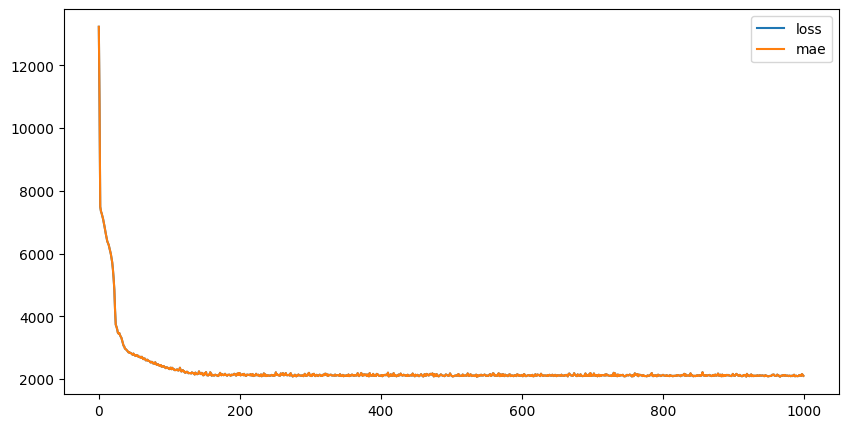

In [16]:
p.visualise()
p.data()

# EarlyStopping Callback
* Stops training after it can't improve anymore
# Data Pre-processing
* Normalization
* Regularization

<Axes: ylabel='Frequency'>

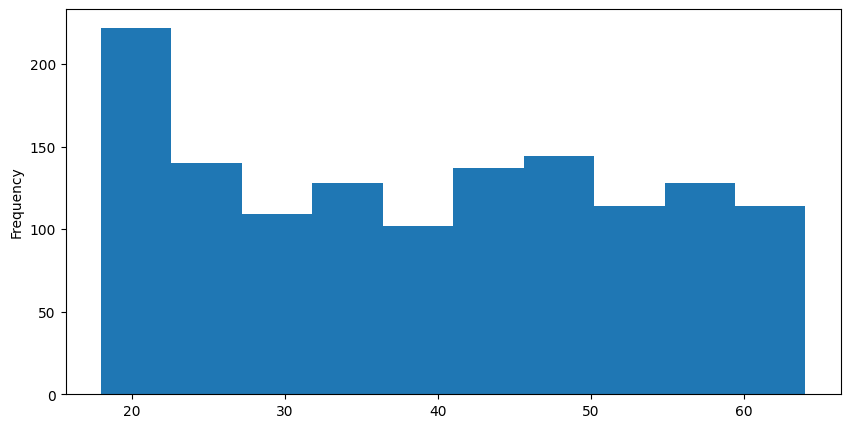

In [20]:
X["age"].plot(kind="hist") # Normalization

# Scaling 
* Typical scaling
* Standardized scaling

### SciKit-Learn Functions MinMaxScaler and StandardScalar are used